## Unsupervised Autoencoder Anomaly Detection

1. Train an autoencoder to capture latent representation of entire dataset
2. Extract the latent representation of the entire dataset
3. Append the reconstruction error as part of the feature vector for the latent representation dataset
4. Perform clustering against the new dataset to determine natural groupings
5. Train another autoencoder against datapoints within groupings treated as normal
6. Apply autothresholding with head tail break
7. Test performance

In [1]:
import sys
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import iqr
from matplotlib import pyplot

# Local imports
sys.path.append('..')

from lib.autoencoder import Autoencoder
from lib.autoencoder_dataset import AutoencoderDataset

## Experimental Parameters

In [2]:
# Label column
label_column = 'y'

ds_train_file = "../Datasets/kddcup99_train.csv"
ds_test_file = "../Datasets/kddcup99_test.csv"

# Dataframe instance for training data
df_train = pd.read_csv(ds_train_file)
# Dataframe instance for test data
df_test = pd.read_csv(ds_test_file)

# Expected number of features
n_features = 40

# Extracted dataframe for all training values without labels
df_train_x = df_train.drop([label_column], axis=1)
# Extracted dataframe for all labels of training data
df_train_y = df_train[label_column]

# Extracted dataframe for all test values without labels
df_test_x = df_test.drop(['y'], axis=1)
# Extracted dataframe for all test labels of testing data
df_test_y = df_test['y']

# Autoencoder parameter for layers. First element is the size of the input vector. Succeeding values are hidden layers for the encoder
layers = [40, 30]

# Autoencoder parameter for hidden activation
h_activation = 'relu'

# Autoencoder parameter for output activation
o_activation = 'sigmoid'

# Autoencoder parameter for learning rate
learning_rate = 0.000001

# Torch parameter for device
device = 'cpu'

# Training parameter for number of epochs
epochs = 20

# Training parameter for batch size
batch_size = 10

# Loss function
loss_fn = nn.MSELoss()

# DBSCAN parameter eps
eps = 0.04

# DBSCAN parameter minimum samples
min_samples = 5

## Train Autoencoder Model

The first autoencoder will attempt to get the latent representation of the data regardless of the labels.

In [3]:
model = Autoencoder(layers=layers, h_activation=h_activation, o_activation=o_activation, device=device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Represent the training data as x
x = torch.tensor(df_train_x.values).float().to(device)

# Load the dataset
train_ds = AutoencoderDataset(x=x)

# Create a DataLoader instance
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=False)

# The training process
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Feed forward
        predictions = model(data)
        
        loss = loss_fn(predictions, targets)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update tqdm
        loop.set_postfix(loss=loss.item())
        
print("Done training!")

Epoch: 0


  0%|                                                                                                                                                                                     | 0/4601 [00:00<?, ?it/s]/home/ralampay/workspace/notebooks/env/lib/python3.9/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:12<00:00, 358.52it/s, loss=0.237]


Epoch: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:11<00:00, 389.06it/s, loss=0.233]


Epoch: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:18<00:00, 253.94it/s, loss=0.228]


Epoch: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:16<00:00, 271.31it/s, loss=0.223]


Epoch: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:15<00:00, 290.86it/s, loss=0.217]


Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:15<00:00, 291.41it/s, loss=0.211]


Epoch: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:11<00:00, 409.47it/s, loss=0.204]


Epoch: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:11<00:00, 401.96it/s, loss=0.196]


Epoch: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:10<00:00, 437.53it/s, loss=0.188]


Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:12<00:00, 362.62it/s, loss=0.179]


Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:11<00:00, 409.38it/s, loss=0.17]


Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:12<00:00, 374.15it/s, loss=0.16]


Epoch: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:11<00:00, 386.17it/s, loss=0.151]


Epoch: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:12<00:00, 367.61it/s, loss=0.141]


Epoch: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:13<00:00, 336.98it/s, loss=0.131]


Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:12<00:00, 357.58it/s, loss=0.121]


Epoch: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:12<00:00, 373.20it/s, loss=0.111]


Epoch: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:10<00:00, 425.24it/s, loss=0.101]


Epoch: 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:11<00:00, 394.43it/s, loss=0.0911]


Epoch: 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4601/4601 [00:13<00:00, 347.32it/s, loss=0.0818]

Done training!


## Compression

Using the trained autoencoder, compress the data to latent space and create a new data frame containing latent vectors and reconstruction errors.

In [4]:
z = model.encode(x).detach().cpu().numpy().astype(np.float32)

columns = []

for i in range(len(z[0])):
    columns.append("x{}".format(i))

df_z = pd.DataFrame(z, columns=columns)

# Normalize the data with MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
z_scaled = min_max_scaler.fit_transform(df_z.values)

# Reassign to df_z
df_z = pd.DataFrame(z_scaled, columns=columns)

# Fetch the errors per data
predictions = model(x)
targets = x

x_loss = nn.MSELoss(reduction='none')(predictions, targets).sum(axis=1).detach().cpu().numpy().astype(np.float32)
df_z['error'] = x_loss

df_z

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x21,x22,x23,x24,x25,x26,x27,x28,x29,error
0,0.793240,0.826811,0.000000,0.634476,0.0,0.363471,0.541753,0.406474,0.277373,0.465755,...,0.000000,0.000000,0.483487,0.454220,0.0,0.000000,0.244190,0.302358,0.322059,5.236656
1,0.788108,0.362938,0.161218,0.366993,0.0,0.389249,0.087326,0.286169,0.316868,0.397639,...,0.347521,0.000000,0.648108,0.267519,0.0,0.140804,0.198607,0.243114,0.317519,5.431109
2,0.455536,0.148629,0.055008,0.189248,0.0,0.283654,0.228299,0.402206,0.000000,0.109701,...,0.219753,0.014701,0.147582,0.272677,0.0,0.000000,0.367231,0.310925,0.305324,6.148790
3,0.241962,0.711267,0.110588,0.526672,0.0,0.318677,0.788280,1.000000,0.536704,0.358023,...,0.321377,0.034238,0.490966,0.562130,0.0,0.000000,0.487425,0.175516,0.529104,4.761903
4,0.251684,0.698637,0.134919,0.529032,0.0,0.325630,0.769554,0.982958,0.532264,0.341555,...,0.331272,0.039653,0.476847,0.547436,0.0,0.000000,0.485895,0.159511,0.516632,4.721280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46004,0.650656,0.798774,0.062688,0.319400,0.0,0.526098,0.499348,0.646661,0.584388,0.662517,...,0.475805,0.387673,0.514687,0.576287,0.0,0.000000,0.342431,0.292779,0.382569,3.738620
46005,0.592062,0.566196,0.000000,0.174644,0.0,0.426163,0.583065,0.668464,0.650636,0.541520,...,0.757745,0.107177,0.721660,0.712792,0.0,0.000000,0.537675,0.032628,0.697988,3.176559
46006,0.689835,0.706366,0.000000,0.388670,0.0,0.476489,0.594329,0.656055,0.717538,0.695643,...,0.571234,0.285999,0.706444,0.751561,0.0,0.000000,0.480430,0.144457,0.659397,3.020452
46007,0.592263,0.538188,0.000000,0.193895,0.0,0.467956,0.565733,0.690400,0.662287,0.543637,...,0.820098,0.137484,0.769343,0.734681,0.0,0.000000,0.578817,0.083559,0.724466,3.245474


## Clustering

Given the new dataset containing latent vectors and reconstruction error, we'll then perform clustering to form natural groupings.

In [5]:
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df_z.values)

unique_labels = np.unique(clustering.labels_)

print("Cluster labels: {}".format(unique_labels))

df_z_with_cluster_labels = df_z.copy()
df_z_with_cluster_labels['cluster_label'] = clustering.labels_

for cluster_label in unique_labels:
    count = len(df_z_with_cluster_labels[df_z_with_cluster_labels['cluster_label'] == cluster_label])
    print("Count for Cluster {}: {}".format(cluster_label, count))
    
df_z_with_cluster_labels

Cluster labels: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192]
Count for Cluster -1: 6537
Count for Cluster 0: 7
Count for Cluster 1: 9
Count for Cluster 2: 5
Count for Cluster 3: 8
Count for Cluster 4: 5
Count for Cluster 5: 226
Count for Cluster 6: 33402
Co

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x22,x23,x24,x25,x26,x27,x28,x29,error,cluster_label
0,0.793240,0.826811,0.000000,0.634476,0.0,0.363471,0.541753,0.406474,0.277373,0.465755,...,0.000000,0.483487,0.454220,0.0,0.000000,0.244190,0.302358,0.322059,5.236656,-1
1,0.788108,0.362938,0.161218,0.366993,0.0,0.389249,0.087326,0.286169,0.316868,0.397639,...,0.000000,0.648108,0.267519,0.0,0.140804,0.198607,0.243114,0.317519,5.431109,-1
2,0.455536,0.148629,0.055008,0.189248,0.0,0.283654,0.228299,0.402206,0.000000,0.109701,...,0.014701,0.147582,0.272677,0.0,0.000000,0.367231,0.310925,0.305324,6.148790,-1
3,0.241962,0.711267,0.110588,0.526672,0.0,0.318677,0.788280,1.000000,0.536704,0.358023,...,0.034238,0.490966,0.562130,0.0,0.000000,0.487425,0.175516,0.529104,4.761903,-1
4,0.251684,0.698637,0.134919,0.529032,0.0,0.325630,0.769554,0.982958,0.532264,0.341555,...,0.039653,0.476847,0.547436,0.0,0.000000,0.485895,0.159511,0.516632,4.721280,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46004,0.650656,0.798774,0.062688,0.319400,0.0,0.526098,0.499348,0.646661,0.584388,0.662517,...,0.387673,0.514687,0.576287,0.0,0.000000,0.342431,0.292779,0.382569,3.738620,-1
46005,0.592062,0.566196,0.000000,0.174644,0.0,0.426163,0.583065,0.668464,0.650636,0.541520,...,0.107177,0.721660,0.712792,0.0,0.000000,0.537675,0.032628,0.697988,3.176559,6
46006,0.689835,0.706366,0.000000,0.388670,0.0,0.476489,0.594329,0.656055,0.717538,0.695643,...,0.285999,0.706444,0.751561,0.0,0.000000,0.480430,0.144457,0.659397,3.020452,19
46007,0.592263,0.538188,0.000000,0.193895,0.0,0.467956,0.565733,0.690400,0.662287,0.543637,...,0.137484,0.769343,0.734681,0.0,0.000000,0.578817,0.083559,0.724466,3.245474,6


## Visualizing Clusters

Use TSNE to reduce to 3 dimensions for visualization and plotly 3d scatterplot for visualization.

**Documentation:**
* **TSNE:**: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
* **Plotly 3D Scatterplot:**: https://plotly.com/python/3d-scatter-plots/

In [6]:
# Fit a TSNE model with 3 dimensions
# z_embedded = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(df_z.values)

# # Create a new data frame for result of tsne and attach cluster label
# df_z_embedded = pd.DataFrame(z_embedded, columns=['x', 'y', 'z'])
# df_z_embedded['cluster_label'] = df_z_with_cluster_labels['cluster_label']

# # Visualize with 3D scatterplot
# fig = px.scatter_3d(df_z_embedded, x='x', y='y', z='z', color='cluster_label')
# fig.show()

## Training for Perceived Normal Data

We now train a new autoencoder model for data points whose cluster_label is not equal to -1. This will serve as our prediction model for auto-thresholding later on.

In [7]:
df_normal = df_train_x.copy()
df_normal = df_normal[df_z_with_cluster_labels['cluster_label'] != -1]

df_normal

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39
5,0.0,1.0,0.514821,0.0,0.000235,0.000000,0.333333,0.0,0.0,0.0,...,0.003922,0.027451,1.0,0.0,1.00,0.57,0.0,0.0,0.0,0.0
6,0.0,1.0,0.514821,0.0,0.000235,0.000000,0.333333,0.0,0.0,0.0,...,0.003922,0.035294,1.0,0.0,1.00,0.56,0.0,0.0,0.0,0.0
7,0.0,1.0,0.514821,0.0,0.000235,0.000000,0.333333,0.0,0.0,0.0,...,0.003922,0.043137,1.0,0.0,1.00,0.55,0.0,0.0,0.0,0.0
9,0.0,1.0,0.514821,0.0,0.000235,0.000000,0.333333,0.0,0.0,0.0,...,0.003922,0.050980,1.0,0.0,1.00,0.54,0.0,0.0,0.0,0.0
10,0.0,1.0,0.514821,0.0,0.000235,0.000000,0.333333,0.0,0.0,0.0,...,0.003922,0.066667,1.0,0.0,1.00,0.53,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46002,0.0,0.0,0.000000,0.0,0.000044,0.001747,0.000000,0.0,0.0,0.0,...,0.760784,1.000000,1.0,0.0,0.01,0.03,0.0,0.0,0.0,0.0
46005,0.0,0.0,0.000000,0.0,0.000036,0.000778,0.000000,0.0,0.0,0.0,...,0.784314,1.000000,1.0,0.0,0.00,0.02,0.0,0.0,0.0,0.0
46006,0.0,0.0,0.000000,0.0,0.000032,0.001299,0.000000,0.0,0.0,0.0,...,0.482353,1.000000,1.0,0.0,0.01,0.06,0.0,0.0,0.0,0.0
46007,0.0,0.0,0.000000,0.0,0.000054,0.000553,0.000000,0.0,0.0,0.0,...,1.000000,1.000000,1.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0


In [8]:
# Represent the training data as x
x = torch.tensor(df_normal.values).float().to(device)

# Load the dataset
train_ds = AutoencoderDataset(x=x)

# Create a DataLoader instance
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=False)

# The training process
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Feed forward
        predictions = model(data)
        
        loss = loss_fn(predictions, targets)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update tqdm
        loop.set_postfix(loss=loss.item())
        
print("Done training!")

Epoch: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:12<00:00, 327.14it/s, loss=0.0715]


Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 329.97it/s, loss=0.0639]


Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:10<00:00, 393.97it/s, loss=0.0566]


Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:09<00:00, 398.26it/s, loss=0.0498]


Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 347.92it/s, loss=0.0436]


Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 354.22it/s, loss=0.038]


Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 353.34it/s, loss=0.0329]


Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 351.90it/s, loss=0.0284]


Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 345.69it/s, loss=0.0245]


Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 352.11it/s, loss=0.021]


Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 349.25it/s, loss=0.0181]


Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 354.40it/s, loss=0.0156]


Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 356.45it/s, loss=0.0135]


Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 356.93it/s, loss=0.0117]


Epoch: 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 343.25it/s, loss=0.0103]


Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 345.57it/s, loss=0.00906]


Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 345.27it/s, loss=0.00808]


Epoch: 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 342.48it/s, loss=0.0073]


Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:12<00:00, 312.01it/s, loss=0.00667]


Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:11<00:00, 334.30it/s, loss=0.00616]

Done training!


## Threshold Computation

Using reconstruction errors, compute for the reconstruction threshold value.

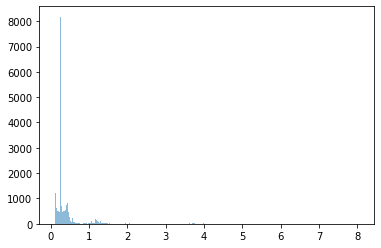

Bin Width: 0.010862015774920339
Num Bins: 724
Max Loss: 7.961540222167969
Min Loss: 0.0947180986404419
Min Bin: 0.0947180986404419
Max Bin: 8.056258201599121
Optimal Threshold: 1.3868188943652164


In [9]:
"""
Utility Functions
"""
# Head tail break function
def htb(data):
    outp = []
    
    def htb_inner(data):
        data_length = float(len(data))
        data_mean = sum(data) / data_length
        
        head = [_ for _ in data if _ > data_mean]
        outp.append(data_mean)
        
        while len(head) > 1 and len(head) / data_length < 0.40:
            return htb_inner(head)
        
    htb_inner(data)
    
    return outp

# Determine a breakpoint
def fetch_threshold(bins, counts, break_point):
    index = 0
    latest_min = 999999
    threshold = -1
    
    for i in range(len(counts)):
        diff = abs(counts[i] - break_point)
        
        if diff <= latest_min:
            latest_min = diff
            index = i
            threshold = ((bins[i + 1] - bins[i]) / 2) + bins[i]
            
    return threshold

predictions = model(x)
targets = x

x_loss = nn.MSELoss(reduction='none')(predictions, targets).sum(axis=1).detach().cpu().numpy().astype(np.float32)

max_loss = np.max(x_loss)
min_loss = np.min(x_loss)

# Compute the optimal bin width using Freedman Diaconis rule
bin_width = 2 * (iqr(x_loss) / (len(x_loss) ** (1./3)))
num_bins = int((max_loss - min_loss) / bin_width)

# Create the histogram
min_bin = np.min(x_loss)
max_bin = np.max(x_loss) + min_bin

step = (max_bin - min_bin) / num_bins

bins = np.arange(min_bin, max_bin, step)

hist, bins = np.histogram(x_loss, bins=bins)

pyplot.hist(x_loss, bins, alpha=0.5)
pyplot.show()

print("Bin Width: {}".format(bin_width))
print("Num Bins: {}".format(num_bins))
print("Max Loss: {}".format(max_loss))
print("Min Loss: {}".format(min_loss))
print("Min Bin: {}".format(min_bin))
print("Max Bin: {}".format(max_bin))



# Determine breaks
breaks = htb(hist)

possible_thresholds = []

for b in breaks:
    t = fetch_threshold(bins, hist, b)
    possible_thresholds.append(t)

optimal_threshold = max(possible_thresholds)

print("Optimal Threshold: {}".format(optimal_threshold))

## Compute for Anomalies

In [10]:
# Convert test data to tensor
x = torch.tensor(df_test_x.values).float().to(device)

predictions = model(x)
targets = x

# Get reconstruction error
x_loss = nn.MSELoss(reduction='none')(predictions, targets).sum(axis=1).detach().cpu().numpy().astype(np.float32)

# If reconstruction error is >= than the optimal threshold, we consider it an anomaly
bool_arr = x_loss >= optimal_threshold

# Convert anomaly labels to -1 if True and 1 if False
anomaly_predictions = np.array([-1 if elem else 1 for elem in bool_arr])

# Build dataframe for test data and attach predictions
df_test_x_with_labels = df_test_x.copy()
df_test_x_with_labels['y'] = anomaly_predictions

df_test_x_with_labels

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31,x32,x33,x34,x35,x36,x37,x38,x39,y
0,0.0,0.000000,0.335534,0.593385,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.003922,0.01,1.0,1.0,0.0,1.0,1.0,0.0,0.0,-1
1,0.0,0.000000,0.335534,0.593385,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.003922,0.01,1.0,1.0,0.0,1.0,1.0,0.0,0.0,-1
2,0.0,0.000000,0.335534,0.593385,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.003922,0.01,1.0,1.0,0.0,1.0,1.0,0.0,0.0,-1
3,0.0,0.000000,0.335534,0.593385,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.003922,0.01,1.0,1.0,0.0,1.0,1.0,0.0,0.0,-1
4,0.0,0.000000,0.335534,0.593385,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.003922,0.01,1.0,1.0,0.0,1.0,1.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.0,0.484582,0.255578,0.000000,0.000007,0.000025,0.0,0.0,0.0,0.0,...,1.000000,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2096,0.0,1.000000,0.514821,0.000000,0.000005,0.000000,0.0,0.0,0.0,0.0,...,0.215686,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1
2097,0.0,1.000000,0.514821,0.000000,0.000005,0.000000,0.0,0.0,0.0,0.0,...,0.219608,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1
2098,0.0,1.000000,0.514821,0.000000,0.000005,0.000000,0.0,0.0,0.0,0.0,...,0.262745,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1


In [11]:
# # Fit a TSNE model with 3 dimensions
# z_embedded = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(df_test_x_with_labels.drop(columns=['y'], axis=1).values)

# # Create a new data frame for result of tsne and attach cluster label
# df_z_embedded = pd.DataFrame(z_embedded, columns=['x', 'y', 'z'])
# df_z_embedded['y'] = anomaly_predictions

# # Visualize with 3D scatterplot
# fig = px.scatter_3d(df_z_embedded, x='x', y='y', z='z', color='y')
# fig.show()

## Evaluation of Results

In [12]:
ground_truth = np.array([1 if elem == 1 else -1 for elem in df_test_y.values])

y_truth = np.array([0 if elem == -1 else 1 for elem in ground_truth])
y_predictions = np.array([0 if elem == -1 else 1 for elem in anomaly_predictions])

tn, fp, fn, tp = confusion_matrix(ground_truth, anomaly_predictions).ravel()
tn, fp, fn, tp = confusion_matrix(y_truth, y_predictions).ravel()

f1 = tp / (tp + 0.5* (fp + fn))

print("True Positive: {}".format(tp))
print("True Negative: {}".format(tn))
print("False Positive: {}".format(fp))
print("False Negative: {}".format(fn))
print("F1: {}".format(f1))

True Positive: 0
True Negative: 263
False Positive: 1837
False Negative: 0
F1: 0.0


In [16]:
def predict_proba(y, bool_a, errors, threshold, max_err):
    results = []
    
    for i in range(len(y)):
        if bool_a[i]:
            prob_anomaly = 0.5 + (1 - (threshold / x_loss[i]))
            
            if prob_anomaly > 1:
                prob_anomaly = 0.99
                
            prob_normal = 1 - prob_anomaly
                
            results.append([prob_normal, prob_anomaly])
        else:
            prob_normal = 0.5 + (1 - (x_loss[i] / threshold))
            
            if prob_normal > 1:
                prob_normal = 0.99
            
            prob_anomaly = 1 - prob_normal
            
            results.append([prob_normal, prob_anomaly])
    
    return results

y_probs = predict_proba(y_truth, bool_arr, x_loss, optimal_threshold, np.max(x_loss))

## ROC Curve and AUC

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

def mapper(arr):
    return arr[0]

probabilities = list(map(mapper, y_probs))
# print(probabilities)

auc = roc_auc_score(y_truth, probabilities)
print('ROC AUC: %f' % auc, '\n')

fpr, tpr, _ = roc_curve(y_truth, probabilities)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.